In [12]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

### 웹 연구 (Web Research) Team 도구

In [14]:
from typing import List
from langchain_community.document_loaders import WebBaseLoader
from langchain_core.tools import tool

@tool
def scrape_webpages(urls: List[str]) -> str:                    # 웹 페이지에서 세부 정보를 스크래핑하기 위한 도구 정의
    """Use requests and bs4 to scrape the provided web pages for detailed information."""

    # 주어진 URL 목록을 사용하여 웹 페이지 로드
    loader = WebBaseLoader(                                     
        web_path=urls,
        header_template={
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.0.0 Safari/537.36",
        },
    )
    
    docs = loader.load()

    doc_list = []

    for doc in docs:
        doc_list.append(f'<Document name="{doc.metadata.get("title", "")}">\n{doc.page_content}\n</Document>')
        

    # 로드된 문서의 제목과 내용을 포함한 문자열 생성
    return "\n\n".join(doc_list)

In [15]:
scraped_data = scrape_webpages.invoke({'urls': ["https://www.khan.co.kr/article/202504041551001"]})

In [16]:
scraped_data

'<Document name="[단독] 한덕수·노태악 통화, 6월3일 대통령 선거일 지정 가닥 - 경향신문">\n\n\n\n\n\n\n\n\n\n\n\n[단독] 한덕수·노태악 통화, 6월3일 대통령 선거일 지정 가닥 - 경향신문\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n경향신문\n\n\n\n오피니언\n\n\n정치\n\n\n경제\n\n\n사회\n\n\n국제\n\n\n문화\n\n\n매거진L\n\n\n[단독] 한덕수·노태악 통화, 6월3일 대통령 선거일 지정 가닥\n\n\n\n마이페이지\n\n\n검색\n\n\n메뉴\n\n\n\n\n\n\n댓글0\n\n\n\n공유하기\n\n\n\n\n뉴스플리\n\n\n\n\n글자크기\n\n\n\n\n\n\n\n\n완독 \n\n\n닫기\n\n\n\n\n\n\n검색\n\n\n\n\n\n경향신문\n\n\n메뉴 펼치기\n메뉴 접기\n\n\n\n\n\n\n오피니언                                \n\n\n\n\n\n전체\n\n\n사설\n\n\n여적\n\n\n기자메모\n\n\n칼럼\n\n\n만평\n\n\n독자마당\n\n\n\n\n\n\n\n\n정치                                \n\n\n\n\n\n전체\n\n\n대통령실\n\n\n국회·정당\n\n\n국방·외교\n\n\n북한·한반도\n\n\n선거\n\n\n정치 일반\n\n\n\n\n\n\n\n\n경제                                \n\n\n\n\n\n전체\n\n\n금융·재테크\n\n\n산업\n\n\nIT·가전\n\n\n부동산\n\n\n자동차\n\n\n생활경제\n\n\n취업·창업\n\n\n경제 일반\n\n\n\n\n\n\n\n\n사회           

In [17]:
from langgraph.graph import START, END
from langchain_core.messages import HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent


# 에이전트 팩토리 클래스
class AgentFactory:
    def __init__(self, model_name):
        self.llm = ChatOpenAI(model=model_name, temperature=0)

    def create_agent_node(self, agent, name: str):
        # 노드 생성 함수
        def agent_node(state):
            result = agent.invoke(state)
            
            return {
                "messages": [
                    HumanMessage(content=result["messages"][-1].content, name=name)
                ]
            }

        return agent_node


# LLM 초기화
llm = ChatOpenAI(model='gpt-4o', temperature=0)

# Agent Factory 인스턴스 생성
agent_factory = AgentFactory('gpt-4o')

### 검색 에이전트

In [18]:
from langchain_teddynote.tools.tavily import TavilySearch

tavily_tool = TavilySearch(max_results=2)                       # 검색 도구 정의(TavilySearch)

search_agent = create_react_agent(llm, tools=[tavily_tool])     # 에이전트 정의

# 에이전트 노드 생성
search_node = agent_factory.create_agent_node(search_agent, name="Searcher")

In [19]:
state_search = {'messages': HumanMessage(content='대구 교보문고', name='Searcher')}

In [20]:
search_node(state_search)

{'messages': [HumanMessage(content='대구 교보문고에 대한 정보를 찾았습니다. \n\n1. [교보문고 대구점 - LocalView](https://localview.co.kr/store/detail.asp?seq=600977851): 대구광역시 중구 동성로2가에 위치한 교보문고 대구점은 총 면적 1,900평의 넓은 매장과 15만 종 30만 권의 방대한 도서를 보유하고 있습니다. 다양한 이벤트와 행사를 진행하며, 보유 도서 검색도 가능합니다.\n\n2. [대구점 매장안내 - 교보문고](https://store.kyobobook.co.kr/store-info/004): 이 페이지에서는 대구점의 매장 주소, 영업시간, 주차 요금 안내, 매장 연락처, 내부 안내도 및 행사 소식과 보유 도서의 재고를 확인할 수 있습니다. \n\n더 많은 정보를 원하시면 위의 링크를 통해 확인하실 수 있습니다.', additional_kwargs={}, response_metadata={}, name='Searcher')]}

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal


# 웹 연구 팀 (Web Research Team) Supervisor (감독자 체인)
def create_team_supervisor(model_name, system_prompt, members) -> str:
    # 다음 작업자 선택 옵션 목록 정의
    options_for_next = ["FINISH"] + members

    # 작업자 선택 응답 모델 정의: 다음 작업자를 선택하거나 작업 완료를 나타냄
    class RouteResponse(BaseModel):
        next: Literal[*options_for_next]


    # # ChatPromptTemplate 생성
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next? "
                "Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options_for_next))


    # # LLM 초기화
    llm = ChatOpenAI(model=model_name, temperature=0)

    # # 프롬프트와 LLM을 결합하여 체인 구성
    supervisor_chain = prompt | llm.with_structured_output(RouteResponse)

    return supervisor_chain

In [22]:
supervisor_agent = create_team_supervisor(
    'gpt-4o',
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: Search, WebScraper. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Searcher", "WebScraper"],
)

state = {
        "messages": [
            HumanMessage(
                content="대구 교보문고에 대해서 알려줘" 
            )
        ]
    }

supervisor_agent.invoke(state)

RouteResponse(next='Searcher')

In [23]:
import operator
from typing import List, TypedDict
from typing_extensions import Annotated

from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai.chat_models import ChatOpenAI
from langgraph.prebuilt import create_react_agent


class ResearchState(TypedDict):
    messages: Annotated[List[BaseMessage], operator.add]        # 메시지
    team_members: List[str]                                     # 멤버 에이전트 목록
    next: str                                                   # Supervisor 에이전트에게 다음 작업자를 선택하도록 지시


llm = ChatOpenAI(model='gpt-4o', temperature=0)


# 검색 노드 생성 (Searcher)
search_agent = create_react_agent(llm, tools=[tavily_tool])
search_node = agent_factory.create_agent_node(search_agent, name="Searcher")


# 웹 스크래핑 노드 생성 (WebScraper)
web_scraping_agent = create_react_agent(llm, tools=[scrape_webpages])
web_scraping_node = agent_factory.create_agent_node(web_scraping_agent, name="WebScraper")


# Supervisor 에이전트 생성
supervisor_agent = create_team_supervisor(
    'gpt-4o-mini',
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: Search, WebScraper. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["Searcher", "WebScraper"],
)

In [24]:
def get_next_node(x):
    return x["next"]

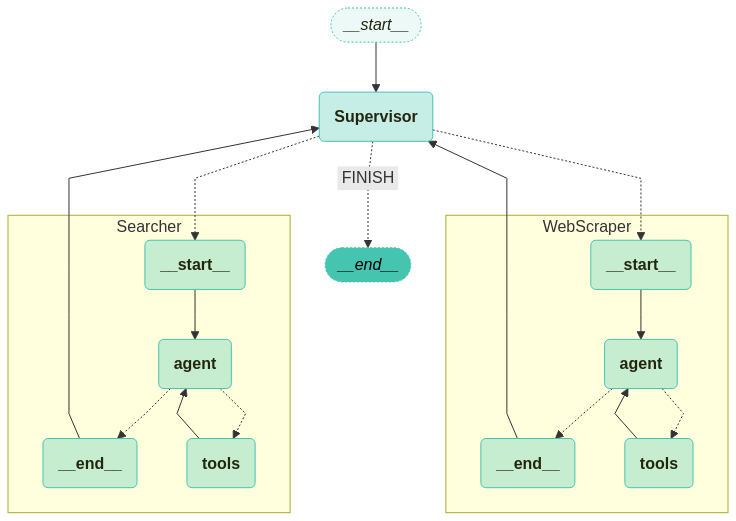

In [25]:
from langchain_teddynote.graphs import visualize_graph
from langgraph.graph import StateGraph
from langgraph.checkpoint.memory import MemorySaver

# 그래프 생성
web_research_graph = StateGraph(ResearchState)

# 노드 추가
web_research_graph.add_node("Searcher", search_node)
web_research_graph.add_node("WebScraper", web_scraping_node)
web_research_graph.add_node("Supervisor", supervisor_agent)

# 엣지 추가
web_research_graph.add_edge("Searcher", "Supervisor")
web_research_graph.add_edge("WebScraper", "Supervisor")

# 조건부 엣지 정의: Supervisor 노드의 결정에 따라 다음 노드로 이동
web_research_graph.add_conditional_edges(
    "Supervisor",
    get_next_node,
    {"Searcher": "Searcher", "WebScraper": "WebScraper", "FINISH": END},
)

# 시작 노드 설정
web_research_graph.set_entry_point("Supervisor")

# 그래프 컴파일
web_research_app = web_research_graph.compile(checkpointer=MemorySaver())

# 그래프 시각화
visualize_graph(web_research_app, xray=True)

In [26]:
from langchain_teddynote.messages import invoke_graph, random_uuid
from langchain_core.runnables import RunnableConfig


def run_graph(app, message: str, recursive_limit: int = 50):
    config = RunnableConfig(recursion_limit=50, configurable={"thread_id": random_uuid()})

    # 질문 입력
    inputs = {
        "messages": [HumanMessage(content=message)],
    }

    # 그래프 실행
    invoke_graph(app, inputs, config)

    return app.get_state(config).values

In [27]:
output = run_graph(
    web_research_app,
    "https://finance.naver.com/news 의 주요 뉴스 정리해서 출력해줘. 출처(URL) 도 함께 출력해줘.",
)


🔄 Node: Supervisor 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
next:
WebScraper

🔄 Node: agent in [WebScraper] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  scrape_webpages (call_BqiAKVwBPSx2bM7AJ4x7yhe9)
 Call ID: call_BqiAKVwBPSx2bM7AJ4x7yhe9
  Args:
    urls: ['https://finance.naver.com/news']

🔄 Node: tools in [WebScraper] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================= Tool Message =================================
Name: scrape_webpages

<Document name="네이버페이 증권">



네이버페이 증권


































메인 메뉴로 바로가기
본문으로 바로가기










네이버





페이






증권






증권 종목명·지수명 검색







검색


자동완성







@code@
@txt@
@market@

@full_txt@
@in_code@
@in_name@
@in_link@
@in_market@




												공모주와 해외 종목은 모바일 페이지로 이동합니다.
											








												현재 자동완성 기능을 사용하고 계십니다.
											









												자동완성 기능이 활성화되었습니다.
					

In [28]:
from langchain_teddynote.messages import invoke_graph, random_uuid
from langchain_core.runnables import RunnableConfig


def run_graph2(app, message: str, recursive_limit: int = 50):
    config = RunnableConfig(recursion_limit=50, configurable={"thread_id": random_uuid()})

    # 질문 입력
    inputs = {
        "messages": [HumanMessage(content=message)],
    }

    i = 1

    for chunk in web_research_app.stream(inputs, config=config, stream_mode="updates"):
        print(f"===== for 시작 {i} =====")

        j = 1

        for state_key, state_value in chunk.items():
            print(f"== for 시작 {i} - {j} ==")
            print(f"state_key : {state_key }")
            print(f"state_value: \n {state_value}")
            print(f"== for  끝 {i} - {j}==")

            j=j+1
        
        print(f"===== for 끝 {i} =====")
        print()

        i=i+1

    return app.get_state(config).values

In [29]:
output = run_graph2(
    web_research_app,
    "https://finance.naver.com/news 의 주요 뉴스 정리해서 출력해줘. 출처(URL) 도 함께 출력해줘.",
)

===== for 시작 1 =====
== for 시작 1 - 1 ==
state_key : Supervisor
state_value: 
 {'next': 'WebScraper'}
== for  끝 1 - 1==
===== for 끝 1 =====

===== for 시작 2 =====
== for 시작 2 - 1 ==
state_key : WebScraper
state_value: 
 {'messages': [HumanMessage(content="Here are the major news highlights from the Naver Finance news page:\n\n1. **DN솔루션즈, IPO 철회…1.5조 공모 “쉽지 않네”**  \n   Source: 헤럴드경제  \n   [Read more](https://finance.naver.com/news)\n\n2. **미·중 관세 협상 불확실성에 외국인·기관 ‘팔자’…코스피 소폭 하락**  \n   Source: 조선비즈  \n   [Read more](https://finance.naver.com/news)\n\n3. **삼성전자, 삼성SDI 유증에 3천340억원 출자…자금 조달 '청신호'**  \n   Source: 연합뉴스  \n   [Read more](https://finance.naver.com/news)\n\n4. **'흑자전환' 성공한 에코프로그룹, 실적 반등에 총력**  \n   Source: 연합뉴스  \n   [Read more](https://finance.naver.com/news)\n\n5. **뒤늦게 ETF 분배금 지급하는 미래에셋운용… 그사이 삼성과 격차 더 벌어졌다**  \n   Source: 조선비즈  \n   [Read more](https://finance.naver.com/news)\n\n6. **코스피 '휴장 전 관망' 2,550대 하락 마감…코스닥 1.3% 내려**  \n   Source: 연합뉴스  \n   [Read more](https://finance

In [30]:
from langchain_teddynote.messages import invoke_graph, random_uuid
from langchain_core.runnables import RunnableConfig


def run_graph2(app, message: str, recursive_limit: int = 50):
    config = RunnableConfig(recursion_limit=50, configurable={"thread_id": random_uuid()})

    # 질문 입력
    inputs = {
        "messages": [HumanMessage(content=message)],
    }


    for chunk in web_research_app.stream(inputs, config=config, stream_mode="updates"):
        
        for state_key, state_value in chunk.items():
            
            print(f"state_key : {state_key }")
            
            if state_key == 'Supervisor':
                print('\n==========================================================================================')
                print(f"🔄 [Node] 웹 연구 팀(Web Research Team) Supervisor 노드 🔄")
                print(f"state_value: \n {state_value}")
                print('==========================================================================================\n')

            elif state_key == 'WebScraper':
                print('\n==========================================================================================')
                print(f"🔄 [Node] 웹 스크래핑 노드 🔄")
                print(f"state_value: \n {state_value}")
                print('==========================================================================================\n')

            elif state_key == 'Searcher':
                print('\n==========================================================================================')
                print(f"🔄 [Node] 웹 검색 노드 🔄")
                print(f"state_value: \n {state_value}")
                print('==========================================================================================\n')

        print()


    return app.get_state(config).values

In [31]:
output = run_graph2(
    web_research_app,
    "https://finance.naver.com/news 의 주요 뉴스 정리해서 출력해줘. 출처(URL) 도 함께 출력해줘.",
)

state_key : Supervisor

🔄 [Node] 웹 연구 팀(Web Research Team) Supervisor 노드 🔄
state_value: 
 {'next': 'WebScraper'}


state_key : WebScraper

🔄 [Node] 웹 스크래핑 노드 🔄
state_value: 
 {'messages': [HumanMessage(content="Here are the major news highlights from the Naver Finance news page:\n\n1. **DN솔루션즈, IPO 철회…1.5조 공모 “쉽지 않네”**  \n   Source: 헤럴드경제\n\n2. **미·중 관세 협상 불확실성에 외국인·기관 ‘팔자’…코스피 소폭 하락**  \n   Source: 조선비즈\n\n3. **삼성전자, 삼성SDI 유증에 3천340억원 출자…자금 조달 '청신호'**  \n   Source: 연합뉴스\n\n4. **'흑자전환' 성공한 에코프로그룹, 실적 반등에 총력**  \n   Source: 연합뉴스\n\n5. **뒤늦게 ETF 분배금 지급하는 미래에셋운용… 그사이 삼성과 격차 더 벌어졌다**  \n   Source: 조선비즈\n\n6. **코스피 '휴장 전 관망' 2,550대 하락 마감…코스닥 1.3% 내려**  \n   Source: 연합뉴스\n\nFor more details, you can visit the [Naver Finance News page](https://finance.naver.com/news).", additional_kwargs={}, response_metadata={}, name='WebScraper')]}


state_key : Supervisor

🔄 [Node] 웹 연구 팀(Web Research Team) Supervisor 노드 🔄
state_value: 
 {'next': 'FINISH'}




In [34]:
output = run_graph2(
    web_research_app,
    "대구 교보문고에 대해서 검색해줘",
)

state_key : Supervisor

🔄 [Node] 웹 연구 팀(Web Research Team) Supervisor 노드 🔄
state_value: 
 {'next': 'Searcher'}


state_key : Searcher

🔄 [Node] 웹 검색 노드 🔄
state_value: 
 {'messages': [HumanMessage(content='대구 교보문고에 대한 정보를 찾았습니다. 대구 교보문고는 대구광역시 중구 동성로2가에 위치하고 있으며, 총 면적 1,900평의 넓은 매장과 15만 종 30만 권의 방대한 도서를 보유하고 있습니다. 이는 대구를 대표하는 문화공간으로, 다양한 이벤트와 행사를 진행하고 있습니다.\n\n자세한 매장 안내는 [교보문고 대구점 매장안내 페이지](https://store.kyobobook.co.kr/store-info/004)에서 확인할 수 있습니다. 여기에서는 매장 주소, 영업시간, 주차 요금 안내, 매장 연락처, 내부 안내도 및 행사 소식과 보유 도서의 재고를 확인할 수 있습니다.', additional_kwargs={}, response_metadata={}, name='Searcher')]}


state_key : Supervisor

🔄 [Node] 웹 연구 팀(Web Research Team) Supervisor 노드 🔄
state_value: 
 {'next': 'WebScraper'}


state_key : WebScraper

🔄 [Node] 웹 스크래핑 노드 🔄
state_value: 
 {'messages': [HumanMessage(content='대구 교보문고에 대한 정보를 다음과 같이 정리했습니다:\n\n- **주소**: 대구광역시 중구 국채보상로 586, 교보생명빌딩 1~3층\n- **영업시간**: 매일 10:00 ~ 22:00\n- **휴점일**: 설날과 추석 당일\n- **매장 문의**: 1544-1900\n\n대구 교보문고는 다양한 도서와 함께 여러 이벤트와 공지사항을 제공하고